## Marker Selection

In [1]:
import pathlib
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import combinations
import numpy as np
import anndata
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import random
from cemba_data.tools.hdf5.anndata import rank_features_groups

## Parameter

In [2]:
cell_tidy_data_path = '/home/hanliu/project/mouse_rostral_brain/ATAC/Metadata/ATAC.cell_tidy_data.msg'
adata_path = '/home/hanliu/project/mouse_rostral_brain/ATAC/AdataForIntegration/HPF-Exc.gene.pass_qc.with_cluster.h5ad'

cluster_col = 'SubType'

cpu = 5
top_n = 50
adj_p_cutoff = 1e-3
log2fc_cutoff = 0.3
min_cluster_cell_number = 10

In [3]:
# Parameters
cell_tidy_data_path = "/home/hanliu/project/mouse_rostral_brain/ATAC/Metadata/ATAC.cell_tidy_data.msg"
adata_path = "/home/hanliu/project/mouse_rostral_brain/ATAC/AdataForIntegration/NonN.gene.pass_qc.with_cluster.h5ad"
cluster_col = "SubType"
cpu = 5
top_n = 50
adj_p_cutoff = 0.001
log2fc_cutoff = 0.3
min_cluster_cell_number = 10


### Stable Parameter

In [4]:
max_test_cell_population = 1000
random_seed = 0
chunk_size = 40
exclude_str = []
output_dir = 'Markers'
output_dir = pathlib.Path(output_dir)
output_dir.mkdir(exist_ok=True)

## Load Data

### Cell Tidy Data and selection

In [5]:
cell_tidy_data = pd.read_msgpack(cell_tidy_data_path)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Adata

In [6]:
adata = anndata.read_h5ad(adata_path)
cell_tidy_data = cell_tidy_data.loc[adata.obs_names].copy()
adata

AnnData object with n_obs × n_vars = 339156 × 53278 
    obs: 'sample', 'barcode', 'TN', 'UM', 'PP', 'UQ', 'CM', 'logUMI', 'landmark', 'umap-1', 'umap-2', 'cluster', 'L1', 'L2', 'L3', 'CellClass', 'MajorType', 'SubType', 'umap_0', 'umap_1', 'Region', 'Order', 'RegionName', 'MajorRegion', 'SubRegion', 'DetailRegion', 'PotentialOverlap (MMB)', 'Slice', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor'
    var: 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'gene_id', 'transcript_id', 'gene_type', 'gene_status', 'transcript_type', 'transcript_status', 'transcript_name', 'exon_number', 'exon_id', 'level', 'havana_gene', 'tag', 'gene_name'

In [7]:
cluster_series = cell_tidy_data[cluster_col].astype(str)
cluster_counts = cluster_series.value_counts()

def check_cluster(cluster, count):
    if count < min_cluster_cell_number:
        return False
    for exclude in exclude_str:
        if exclude in cluster:
            return False
    return True


unique_clusters = [
    cluster for cluster, count in cluster_counts.items()
    if check_cluster(cluster, count)
]
cluster_pairs = list(combinations(unique_clusters, 2))
random.shuffle(cluster_pairs)  # shuffle make parallel more even

print(len(unique_clusters), 'pass filter.')
print(len(cluster_pairs), 'pairwise comparison to test.')

20 pass filter.
190 pairwise comparison to test.


## Basic filter

AnnData object with n_obs × n_vars = 339156 × 18955 
    obs: 'sample', 'barcode', 'TN', 'UM', 'PP', 'UQ', 'CM', 'logUMI', 'landmark', 'umap-1', 'umap-2', 'cluster', 'L1', 'L2', 'L3', 'CellClass', 'MajorType', 'SubType', 'umap_0', 'umap_1', 'Region', 'Order', 'RegionName', 'MajorRegion', 'SubRegion', 'DetailRegion', 'PotentialOverlap (MMB)', 'Slice', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor'
    var: 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'gene_id', 'transcript_id', 'gene_type', 'gene_status', 'transcript_type', 'transcript_status', 'transcript_name', 'exon_number', 'exon_id', 'level', 'havana_gene', 'tag', 'gene_name'

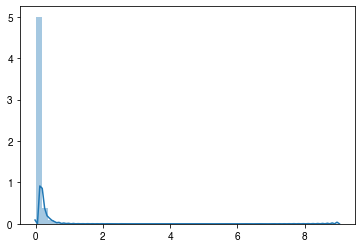

In [8]:
gene_mean = adata.X.mean(axis=0) 
judge = (gene_mean > 0.01) & (gene_mean < 100)
sns.distplot(gene_mean[judge])

adata = adata[:, judge.A1].copy()
adata

In [9]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [10]:
adata.write_h5ad('TEMP_ADATA.h5ad')

## Pairwise test

In [11]:
def get_sig_features(rank_gene_dict):
    pvals_adj = pd.DataFrame(rank_gene_dict['pvals_adj'])
    names = pd.DataFrame(rank_gene_dict['names'])
    logfoldchanges = pd.DataFrame(rank_gene_dict['logfoldchanges'])
    gene_set = set(
        names.where((pvals_adj < adj_p_cutoff)
                    & (logfoldchanges.abs() > log2fc_cutoff)).values.flat)
    return gene_set


def pairwise_tests(pairs):
    adata_path = 'TEMP_ADATA.h5ad'
    adata = anndata.read_h5ad(adata_path)
    total_markers = set()
    pair_marker_count = {}
    for pair in pairs:
        cluster_a, cluster_b = pair
        cluster_a_cells = cluster_series[cluster_series == cluster_a]
        if cluster_a_cells.size > max_test_cell_population:
            cluster_a_cells = cluster_a_cells.sample(max_test_cell_population,
                                                     random_state=random_seed)
        cluster_a_cells = cluster_a_cells.index

        cluster_b_cells = cluster_series[cluster_series == cluster_b]
        if cluster_b_cells.size > max_test_cell_population:
            cluster_b_cells = cluster_b_cells.sample(max_test_cell_population,
                                                     random_state=random_seed)
        cluster_b_cells = cluster_b_cells.index
        cells = cluster_a_cells | cluster_b_cells

        pair_adata = adata[cells, :].copy()
        pair_adata.obs['cluster'] = pair_adata.obs[cluster_col].astype(
            str).astype('category')

        sc.tl.rank_genes_groups(pair_adata,
                                groupby='cluster',
                                n_genes=top_n,
                                method='wilcoxon')
        gene_set = get_sig_features(pair_adata.uns['rank_genes_groups'])
        # drop na
        gene_set = set([i for i in gene_set if isinstance(i, str)])

        total_markers.update(gene_set)
        pair_marker_count[pair] = len(gene_set)
    return total_markers, pair_marker_count

In [12]:
total_markers = set()
pair_marker_counts = {}
with ProcessPoolExecutor(cpu) as executor:
    futures = []
    for chunk_start in range(0, len(cluster_pairs), chunk_size):
        pair_chunk = cluster_pairs[chunk_start:chunk_start + chunk_size]
        future = executor.submit(pairwise_tests, pair_chunk)
        futures.append(future)

    for future in as_completed(futures):
        genes, pair_marker_count = future.result()
        total_markers.update(genes)
        pair_marker_counts.update(pair_marker_count)

## Save results

In [13]:
total_markers = set([i for i in total_markers if isinstance(i, str)])
with open('Markers/rna.cluster_markers.txt', 'w') as f:
    f.write('\n'.join(total_markers))

In [14]:
pair_marker_counts = pd.Series(pair_marker_counts)
marker_counts = pair_marker_counts.reset_index()
marker_counts.columns = ['ClusterA', 'ClusterB', 'GeneCount']
marker_counts.to_csv('Markers/rna.cluster_pair_marker_counts.csv', index=None)

In [15]:
marker_counts[marker_counts['GeneCount'] < 3]

,ClusterA,ClusterB,GeneCount


In [16]:
import subprocess
subprocess.run(['rm', '-f', 'TEMP_ADATA.h5ad'])

CompletedProcess(args=['rm', '-f', 'TEMP_ADATA.h5ad'], returncode=0)

In [17]:
adata = anndata.read_h5ad(adata_path)
marker_adata = adata[:, list(total_markers)]

In [18]:
cell_tidy_data_pseudo = pd.read_msgpack(
'/home/hanliu/project/mouse_rostral_brain/ATAC/SubTypeANN/CellMeta.with_pseudo_cell.msg')
cell_tidy_data_pseudo = cell_tidy_data_pseudo.reindex(marker_adata.obs_names)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
datas = []
cells = []
for cell_name, sub_df in cell_tidy_data_pseudo.groupby('PseudoCell'):
    data = marker_adata[sub_df.index, :].X.sum(axis=0)
    datas.append(data)
    cells.append(cell_name)
data = np.vstack(datas)

In [20]:
pseudo_marker_adata = anndata.AnnData(X=np.array(data).copy(),
                                      obs=pd.DataFrame([], index=cells),
                                      var=marker_adata.var.copy())
pseudo_marker_adata.obs['cluster'] = pseudo_marker_adata.obs.index.map(lambda i: i.split('+')[0])

sc.pp.normalize_per_cell(pseudo_marker_adata)
sc.pp.log1p(pseudo_marker_adata)

pseudo_marker_adata.write_h5ad('Markers/atac.pseudo_cell.cluster_markers.h5ad')
pseudo_marker_adata

... storing 'cluster' as categorical


AnnData object with n_obs × n_vars = 8096 × 1316 
    obs: 'cluster', 'n_counts'
    var: 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'gene_id', 'transcript_id', 'gene_type', 'gene_status', 'transcript_type', 'transcript_status', 'transcript_name', 'exon_number', 'exon_id', 'level', 'havana_gene', 'tag', 'gene_name'

In [21]:
sc.pp.normalize_per_cell(marker_adata)
sc.pp.log1p(marker_adata)

marker_adata.write_h5ad('Markers/atac.cluster_markers.h5ad')
marker_adata

Trying to set attribute `.obs` of view, making a copy.


AnnData object with n_obs × n_vars = 339156 × 1316 
    obs: 'sample', 'barcode', 'TN', 'UM', 'PP', 'UQ', 'CM', 'logUMI', 'landmark', 'umap-1', 'umap-2', 'cluster', 'L1', 'L2', 'L3', 'CellClass', 'MajorType', 'SubType', 'umap_0', 'umap_1', 'Region', 'Order', 'RegionName', 'MajorRegion', 'SubRegion', 'DetailRegion', 'PotentialOverlap (MMB)', 'Slice', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor', 'n_counts'
    var: 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'gene_id', 'transcript_id', 'gene_type', 'gene_status', 'transcript_type', 'transcript_status', 'transcript_name', 'exon_number', 'exon_id', 'level', 'havana_gene', 'tag', 'gene_name'